# ***BackTest Maverick RSI***

## ***Test (Number of Winning/Losing Trades)***

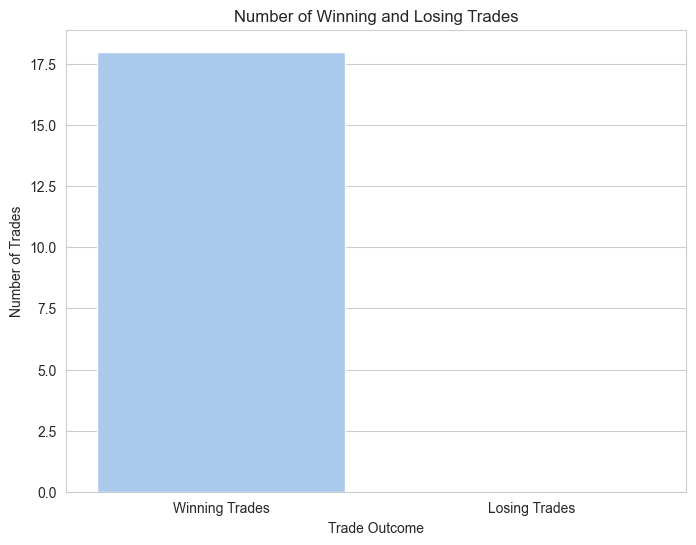

In [67]:
import MetaTrader5 as mt5
import pandas as pd
import ta.momentum as momentum
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import time 

def get_historical_data(symbol, timeframe, number_of_data = 1000):
    # Initialize the MetaTrader 5 terminal
    if not mt5.initialize():
        print("initialize() failed")
        mt5.shutdown()
        return None

    # Retrieve historical data from MetaTrader 5
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, number_of_data)

    # Check if data is retrieved successfully
    if rates is None:
        print("Failed to retrieve historical data.")
        mt5.shutdown()
        return None

    # Transform tuples into a DataFrame
    df = pd.DataFrame(rates)
    df["time"] = pd.to_datetime(df["time"], unit= "s")
    df = df.set_index("time")

    # Shutdown the MetaTrader 5 terminal
    mt5.shutdown()

    return df

def calculate_rsi(df, period = 14):
    try:
        # Use 'window' instead of 'n'
        rsi_indicator = momentum.RSIIndicator(df["close"], window = period)
        df["rsi"] = rsi_indicator.rsi()
    except Exception as e:
        print("Error calculating RSI:", str(e))

def execute_sell_trade(df, symbol, lot_size = 1.0):
    # Get the last row (most recent bar) from the historical data
    current_bar = df.iloc[-1]
    previous_bar = df.iloc[-2]
    
    # Check if RSI is greater than 70 (overbought) and the current close 
    # is lower than the open of the current bar, and the previous close
    # was higher than the open of the previous bar
    if current_bar["rsi"] > 70 and current_bar["close"] < current_bar["open"] \
    and previous_bar["close"] > previous_bar["open"]:
        # Initialize the MetaTrader 5 terminal
        if not mt5.initialize():
            print("initialize() failed")
            mt5.shutdown()
            return

        # Execute a sell trade
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": lot_size,
            "type": mt5.ORDER_TYPE_SELL,
            "price": mt5.symbol_info_tick(symbol).bid,
            "deviation": 10,
            "magic": 0,
            "comment": "RSI Sell Strategy",
            "type_filling": find_filling_mode(symbol),
            "type_time": mt5.ORDER_TIME_GTC
        }
        result = mt5.order_send(request)
        print("Sell Trade Executed:", result.comment)

        # Shutdown the MetaTrader 5 terminal
        mt5.shutdown()

def find_filling_mode(symbol):
    for i in range(2):
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": mt5.symbol_info(symbol).volume_min,
            "type": mt5.ORDER_TYPE_BUY,
            "price": mt5.symbol_info_tick(symbol).ask,
            "type_filling": i,
            "type_time": mt5.ORDER_TIME_GTC
        }
        result = mt5.order_check(request)
        if result.comment == "Done":
            break
    return i
    
def backtest_strategy(symbol, timeframe, initial_capital=10, lot_size=1.0, data_length=1000, period=14):
    # Initialize portfolio variables
    portfolio_value = initial_capital
    num_trades = 0
    num_winning_trades = 0
    num_losing_trades = 0

    # Retrieve historical data
    df = get_historical_data(symbol, timeframe, data_length)

    # Check if the historical data is retrieved successfully
    if df is not None:
        # Calculate RSI
        calculate_rsi(df, period)

        for i in range(1, len(df)):
            current_bar = df.iloc[i]
            previous_bar = df.iloc[i - 1]

            if current_bar["rsi"] > 70 and current_bar["close"] < current_bar["open"] \
            and previous_bar["close"] > previous_bar["open"]:
                # Simulate sell trade
                num_trades += 1
                trade_profit = lot_size * (current_bar["open"] - current_bar["close"])
                portfolio_value += trade_profit

                if trade_profit > 0:
                    num_winning_trades += 1
                else:
                    num_losing_trades += 1

        # Calculate final portfolio value (include any open positions)
        final_bar = df.iloc[-1]
        open_position_value = lot_size * (final_bar["open"] - final_bar["close"])
        portfolio_value += open_position_value

    return portfolio_value, num_trades, num_winning_trades, num_losing_trades

def plot_trade_outcomes(symbol, timeframe, initial_capital=10, lot_size=1.0, data_length=1000, period=14):
    # Run the backtest to get the trade outcomes
    _, num_trades, num_winning_trades, num_losing_trades = backtest_strategy(symbol, timeframe, initial_capital, lot_size, data_length, period)

    # Create a bar plot for trade outcomes
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 6))
    sns.barplot(x=["Winning Trades", "Losing Trades"], y=[num_winning_trades, num_losing_trades], palette="pastel")
    plt.xlabel("Trade Outcome")
    plt.ylabel("Number of Trades")
    plt.title("Number of Winning and Losing Trades")
    plt.show()

# Example usage:
if __name__ == "__main__":
    symbol = "Boom 1000 Index" # Replace with your desired symbol
    timeframe = mt5.TIMEFRAME_M1  # Replace with your desired timeframe
    initial_capital = 10  # Replace with your initial capital
    lot_size = 1.0  # Replace with your desired lot size
    data_length = 1000  # Replace with the number of data points to retrieve
    period = 14  # Replace with the RSI period

    # Perform the backtest and plot the trade outcomes
    plot_trade_outcomes(symbol, timeframe, initial_capital, lot_size, data_length, period)


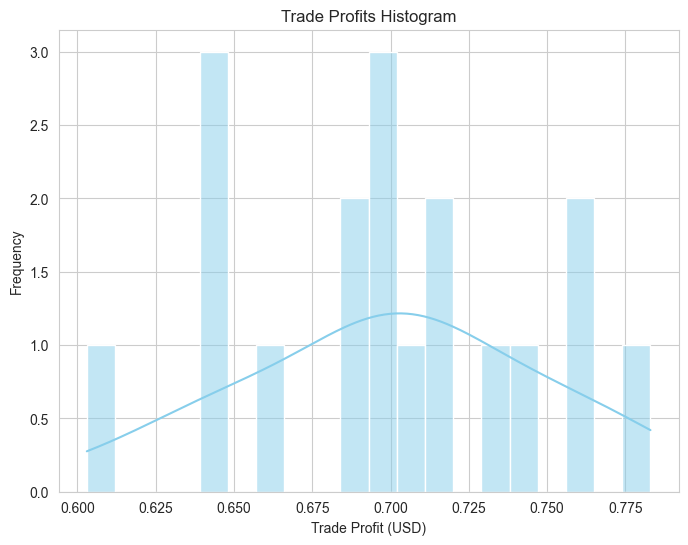

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# ... (previous code) ...

def backtest_strategy(symbol, timeframe, initial_capital=10, lot_size=1.0, data_length=1000, period=14):
    # Initialize portfolio variables
    portfolio_value = initial_capital
    num_trades = 0
    num_winning_trades = 0
    num_losing_trades = 0
    trade_profits = []

    # Retrieve historical data
    df = get_historical_data(symbol, timeframe, data_length)

    # Check if the historical data is retrieved successfully
    if df is not None:
        # Calculate RSI
        calculate_rsi(df, period)

        for i in range(1, len(df)):
            current_bar = df.iloc[i]
            previous_bar = df.iloc[i - 1]

            if current_bar["rsi"] > 70 and current_bar["close"] < current_bar["open"] \
            and previous_bar["close"] > previous_bar["open"]:
                # Simulate sell trade
                num_trades += 1
                trade_profit = lot_size * (current_bar["open"] - current_bar["close"])
                portfolio_value += trade_profit
                trade_profits.append(trade_profit)

                if trade_profit > 0:
                    num_winning_trades += 1
                else:
                    num_losing_trades += 1

        # Calculate final portfolio value (include any open positions)
        final_bar = df.iloc[-1]
        open_position_value = lot_size * (final_bar["open"] - final_bar["close"])
        portfolio_value += open_position_value

    return portfolio_value, num_trades, num_winning_trades, num_losing_trades, trade_profits

def plot_trade_profits(symbol, timeframe, initial_capital=10, lot_size=1.0, data_length=1000, period=14):
    # Run the backtest to get the trade profits
    _, _, _, _, trade_profits = backtest_strategy(symbol, timeframe, initial_capital, lot_size, data_length, period)

    # Create a histogram for trade profits
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 6))
    sns.histplot(trade_profits, bins=20, kde=True, color="skyblue")
    plt.xlabel("Trade Profit (USD)")
    plt.ylabel("Frequency")
    plt.title("Trade Profits Histogram")
    plt.show()

# Example usage:
if __name__ == "__main__":
    symbol = "Boom 1000 Index" # Replace with your desired symbol
    timeframe = mt5.TIMEFRAME_M1  # Replace with your desired timeframe
    initial_capital = 10  # Replace with your initial capital
    lot_size = 1.0  # Replace with your desired lot size
    data_length = 1000  # Replace with the number of data points to retrieve
    period = 14  # Replace with the RSI period

    # Perform the backtest and plot the trade profits histogram
    plot_trade_profits(symbol, timeframe, initial_capital, lot_size, data_length, period)


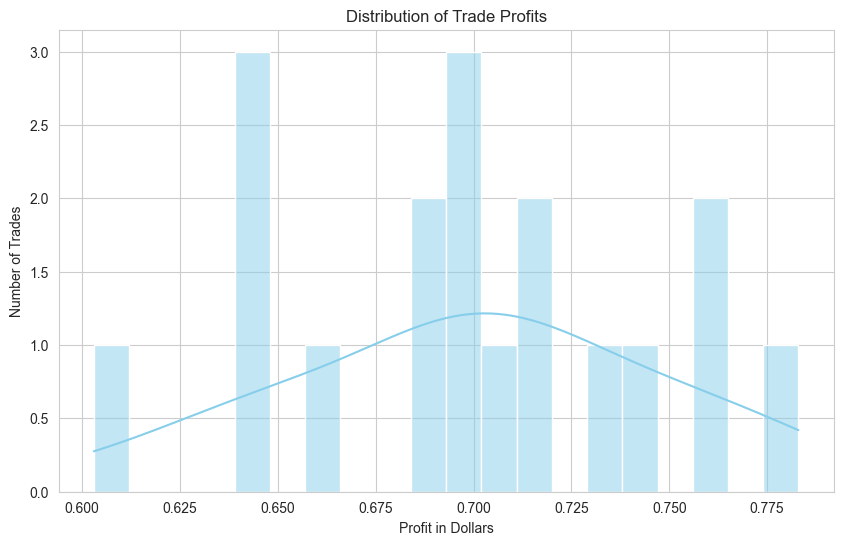

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# ... (previous code) ...

def backtest_strategy(symbol, timeframe, initial_capital=10, lot_size=1.0, data_length=1000, period=14):
    # Initialize portfolio variables
    portfolio_value = initial_capital
    num_trades = 0
    num_winning_trades = 0
    num_losing_trades = 0
    trade_profits = []  # List to store trade profits

    # Retrieve historical data
    df = get_historical_data(symbol, timeframe, data_length)

    # Check if the historical data is retrieved successfully
    if df is not None:
        # Calculate RSI
        calculate_rsi(df, period)

        for i in range(1, len(df)):
            current_bar = df.iloc[i]
            previous_bar = df.iloc[i - 1]

            if current_bar["rsi"] > 70 and current_bar["close"] < current_bar["open"] \
            and previous_bar["close"] > previous_bar["open"]:
                # Simulate sell trade
                num_trades += 1
                trade_profit = lot_size * (current_bar["open"] - current_bar["close"])
                portfolio_value += trade_profit
                trade_profits.append(trade_profit)  # Add trade profit to the list

                if trade_profit > 0:
                    num_winning_trades += 1
                else:
                    num_losing_trades += 1

        # Calculate final portfolio value (include any open positions)
        final_bar = df.iloc[-1]
        open_position_value = lot_size * (final_bar["open"] - final_bar["close"])
        portfolio_value += open_position_value

    return portfolio_value, num_trades, num_winning_trades, num_losing_trades, trade_profits

def plot_trade_profits(symbol, timeframe, initial_capital=10, lot_size=1.0, data_length=1000, period=14):
    # Run the backtest to get trade profits
    _, _, _, _, trade_profits = backtest_strategy(symbol, timeframe, initial_capital, lot_size, data_length, period)

    # Create a histogram for trade profits
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    sns.histplot(trade_profits, bins=20, kde=True, color="skyblue")
    plt.xlabel("Profit in Dollars")
    plt.ylabel("Number of Trades")
    plt.title("Distribution of Trade Profits")
    plt.show()

# Example usage:
if __name__ == "__main__":
    symbol = "Boom 1000 Index" # Replace with your desired symbol
    timeframe = mt5.TIMEFRAME_M1  # Replace with your desired timeframe
    initial_capital = 10  # Replace with your initial capital
    lot_size = 1.0  # Replace with your desired lot size
    data_length = 1000  # Replace with the number of data points to retrieve
    period = 14  # Replace with the RSI period

    # Perform the backtest and plot the trade profits
    plot_trade_profits(symbol, timeframe, initial_capital, lot_size, data_length, period)


## ***Test (Trades Total Results)***

In [70]:
import MetaTrader5 as mt5
import pandas as pd
import ta.momentum as momentum
import time

# (previous code for get_historical_data and calculate_rsi unchanged)

def backtest_strategy(symbol_list, timeframe, initial_capital=10, lot_size=1.0, data_length=1000, period=14, spread=0.0, volume=1):
    # Initialize portfolio variables
    portfolio_value = {symbol: initial_capital for symbol in symbol_list}
    num_trades = {symbol: 0 for symbol in symbol_list}

    for symbol in symbol_list:
        # Retrieve historical data
        df = get_historical_data(symbol, timeframe, data_length)

        # Check if the historical data is retrieved successfully
        if df is not None:
            # Calculate RSI
            calculate_rsi(df, period)

            for i in range(1, len(df)):
                current_bar = df.iloc[i]
                previous_bar = df.iloc[i - 1]

                if current_bar["rsi"] > 70 and current_bar["close"] < current_bar["open"] \
                and previous_bar["close"] > previous_bar["open"]:
                    # Simulate sell trade
                    num_trades[symbol] += 1

                    # Calculate trade profit considering spread and volume
                    trade_profit = lot_size * volume * (current_bar["open"] - current_bar["close"] - spread)
                    portfolio_value[symbol] += trade_profit

            # Calculate final portfolio value (include any open positions)
            final_bar = df.iloc[-1]
            open_position_value = lot_size * volume * (final_bar["open"] - final_bar["close"] - spread)
            portfolio_value[symbol] += open_position_value

    return portfolio_value, num_trades

# Example usage:
if __name__ == "__main__":
    symbol_list = ["Boom 1000 Index", "Boom 500 Index", "Boom 300 Index"] # Replace with your desired symbols
    timeframe = mt5.TIMEFRAME_M1  # Replace with your desired timeframe
    initial_capital = 10  # Replace with your initial capital
    lot_size = 1.0  # Replace with your desired lot size
    data_length = 1000  # Replace with the number of data points to retrieve
    period = 14  # Replace with the RSI period
    spread = 0.01  # Replace with the spread value (e.g., 0.01 represents 1 pip)
    volume = 1  # Replace with the volume of lots traded in each trade

    # Perform the backtest and get the trade outcomes for each symbol
    portfolio_value, num_trades = backtest_strategy(symbol_list, timeframe, initial_capital, lot_size, data_length, period, spread, volume)

    for symbol in symbol_list:
        profit = portfolio_value[symbol] - initial_capital
        print(f"Symbol: {symbol}")
        print(f"Initial Portfolio Value: ${initial_capital:.2f}")
        print(f"Final Portfolio Value: ${portfolio_value[symbol]:.2f}")
        print(f"Profit Value: ${profit:.2f}")
        print(f"Number of Trades: {num_trades[symbol]}")
        print("------------------------")

Symbol: Boom 1000 Index
Initial Portfolio Value: $10.00
Final Portfolio Value: $22.67
Profit Value: $12.67
Number of Trades: 18
------------------------
Symbol: Boom 500 Index
Initial Portfolio Value: $10.00
Final Portfolio Value: $21.82
Profit Value: $11.82
Number of Trades: 23
------------------------
Symbol: Boom 300 Index
Initial Portfolio Value: $10.00
Final Portfolio Value: $11.94
Profit Value: $1.94
Number of Trades: 9
------------------------


In [80]:
import MetaTrader5 as mt5
import pandas as pd
import ta.momentum as momentum
import time

# (previous code for calculate_rsi unchanged)

def get_historical_data(symbol, timeframe, start_date, end_date):
    if not mt5.initialize():
        mt5.shutdown()
        return None

    # Convert start and end dates to timestamp
    start_timestamp = int(pd.Timestamp(start_date).timestamp())
    end_timestamp = int(pd.Timestamp(end_date).timestamp())

    rates = mt5.copy_rates_range(symbol, timeframe, start_timestamp, end_timestamp)

    if rates is None:
        mt5.shutdown()
        return None

    df = pd.DataFrame(rates)
    df["time"] = pd.to_datetime(df["time"], unit="s")
    df = df.set_index("time")

    mt5.shutdown()

    return df

def backtest_strategy(symbol_list, timeframe, start_date, end_date, initial_capital=10, lot_size=1.0, period=14, spread=0.0, volume=1):
    # Initialize portfolio variables
    portfolio_value = {symbol: initial_capital for symbol in symbol_list}
    num_trades = {symbol: 0 for symbol in symbol_list}

    for symbol in symbol_list:
        # Retrieve historical data for the specified date range
        df = get_historical_data(symbol, timeframe, start_date, end_date)

        # Check if the historical data is retrieved successfully
        if df is not None:
            # Calculate RSI
            calculate_rsi(df, period)

            for i in range(1, len(df)):
                current_bar = df.iloc[i]
                previous_bar = df.iloc[i - 1]

                if current_bar["rsi"] > 70 and current_bar["close"] < current_bar["open"] \
                and previous_bar["close"] > previous_bar["open"]:
                    # Simulate sell trade
                    num_trades[symbol] += 1

                    # Calculate trade profit considering spread and volume
                    trade_profit = lot_size * volume * (current_bar["open"] - current_bar["close"] - spread)
                    portfolio_value[symbol] += trade_profit

            # Calculate final portfolio value (include any open positions)
            final_bar = df.iloc[-1]
            open_position_value = lot_size * volume * (final_bar["open"] - final_bar["close"] - spread)
            portfolio_value[symbol] += open_position_value

    return portfolio_value, num_trades

# Example usage:
if __name__ == "__main__":
    symbol_list = ["Boom 1000 Index", "Boom 500 Index", "Boom 300 Index"] # Replace with your desired symbols
    timeframe = mt5.TIMEFRAME_M1  # Replace with your desired timeframe
    start_date = "2023-08-01"  # Replace with your desired start date
    end_date = "2023-08-02"  # Replace with your desired end date
    initial_capital = 10  # Replace with your initial capital
    lot_size = 1.0  # Replace with your desired lot size
    period = 14  # Replace with the RSI period
    spread = 0.01  # Replace with the spread value (e.g., 0.01 represents 1 pip)
    volume = 1  # Replace with the volume of lots traded in each trade

    # Perform the backtest and get the trade outcomes for each symbol
    portfolio_value, num_trades = backtest_strategy(symbol_list, timeframe, start_date, end_date, initial_capital, lot_size, period, spread, volume)

    for symbol in symbol_list:
        profit = portfolio_value[symbol] - initial_capital
        print("------------------------")
        print(f"Symbol: {symbol}")
        print(f"Initial Portfolio Value: ${initial_capital:.2f}")
        print(f"Final Portfolio Value: ${portfolio_value[symbol]:.2f}")
        print(f"Profit Value: ${profit:.2f}")
        print(f"Number of Trades: {num_trades[symbol]}")


------------------------
Symbol: Boom 1000 Index
Initial Portfolio Value: $10.00
Final Portfolio Value: $44.86
Profit Value: $34.86
Number of Trades: 53
------------------------
Symbol: Boom 500 Index
Initial Portfolio Value: $10.00
Final Portfolio Value: $23.13
Profit Value: $13.13
Number of Trades: 25
------------------------
Symbol: Boom 300 Index
Initial Portfolio Value: $10.00
Final Portfolio Value: $15.02
Profit Value: $5.02
Number of Trades: 25


## ***Test (History of trades on last 1000 candles)***

In [60]:
import MetaTrader5 as mt5
import pandas as pd
import ta.momentum as momentum
import plotly.graph_objects as go
import time
from datetime import datetime
from secret import credentials

def backtest_strategy(symbol, timeframe, initial_capital=10, lot_size=1.0, data_length=1000, period=14):
    # Initialize portfolio variables
    portfolio_value = initial_capital
    num_trades = 0
    num_winning_trades = 0
    trade_entry_points = []
    trade_exit_points = []

    # Retrieve historical data
    df = get_historical_data(symbol, timeframe, data_length)

    # Check if the historical data is retrieved successfully
    if df is not None:
        # Calculate RSI
        calculate_rsi(df, period)

        for i in range(1, len(df)):
            current_bar = df.iloc[i]
            previous_bar = df.iloc[i - 1]

            if current_bar["rsi"] > 70 and current_bar["close"] < current_bar["open"] \
                    and previous_bar["close"] > previous_bar["open"]:
                # Simulate sell trade
                num_trades += 1
                portfolio_value += lot_size * (current_bar["open"] - current_bar["close"])

                # Record trade entry and exit points
                trade_entry_points.append((current_bar.name, current_bar["open"]))
                trade_exit_points.append((current_bar.name, current_bar["close"]))

                if current_bar["close"] > current_bar["open"]:
                    num_winning_trades += 1

        # Calculate final portfolio value (include any open positions)
        final_bar = df.iloc[-1]
        open_position_value = lot_size * (final_bar["open"] - final_bar["close"])
        portfolio_value += open_position_value

    return portfolio_value, num_trades, num_winning_trades, num_trades - num_winning_trades, trade_entry_points, trade_exit_points

def plot_trade_outcomes(symbol, timeframe, initial_capital=10, lot_size=1.0, data_length=1000, period=14):
    # Run the backtest to get the trade outcomes and trade points
    _, num_trades, num_winning_trades, num_losing_trades, trade_entry_points, trade_exit_points = backtest_strategy(symbol, timeframe, initial_capital, lot_size, data_length, period)

    # Retrieve historical data
    df = get_historical_data(symbol, timeframe, data_length)

    # Create a candlestick chart
    candlestick = go.Candlestick(x=df.index,
                                 open=df["open"],
                                 high=df["high"],
                                 low=df["low"],
                                 close=df["close"],
                                 name="Candlesticks")

    # Create a scatter plot for trade entry points
    entry_scatter = go.Scatter(x=[entry_point[0] for entry_point in trade_entry_points],
                               y=[entry_point[1] for entry_point in trade_entry_points],
                               mode='markers',
                               marker=dict(symbol='triangle-up', size=10, color='blue'),
                               name="Trade Entry")

    # Create a scatter plot for trade exit points
    exit_scatter = go.Scatter(x=[exit_point[0] for exit_point in trade_exit_points],
                              y=[exit_point[1] for exit_point in trade_exit_points],
                              mode='markers',
                              marker=dict(symbol='triangle-down', size=10, color='red'),
                              name="Trade Exit")

    # Layout for the candlestick chart
    layout = go.Layout(title=f"Candlestick Chart with Trades ({symbol})",
                       xaxis=dict(title="Time"),
                       yaxis=dict(title="Price"))

    # Create a figure with candlestick and scatter plots
    fig = go.Figure(data=[candlestick, entry_scatter, exit_scatter], layout=layout)

    # Show the figure
    fig.show()

if __name__ == "__main__":
    symbol = "Boom 1000 Index"  # Replace with your desired symbol
    timeframe = mt5.TIMEFRAME_M1  # Replace with your desired timeframe
    initial_capital = 10  # Replace with your initial capital
    lot_size = 1.0  # Replace with your desired lot size
    data_length = 1000  # Replace with the number of data points to retrieve
    period = 14  # Replace with the RSI period

    # Perform the backtest and plot the trade outcomes on a candlestick chart using Plotly
    plot_trade_outcomes(symbol, timeframe, initial_capital, lot_size, data_length, period)
